# Classification Using TF-IDF & Logistic Regression

The goal of the notebook is to experiment with different modeling techniques for multiclass multi-label classification. For mutliclass classification, where you have a target that has mutually exclusive classes, it is relatively straight forward to perform the classification using the `sklearn` package. But, for multi-label classification, we need to go up and beyond applying techniques like,           
1. **OneVsRest Classification**: Here we build one model for each class, assuming the class we are interested as the `One` and everything else as the `Rest` class.     

2. **Classifier Chains**: Similar to OneVsRest, this method builds one model for each class, but with a slight twist. The output predictions of each model act as input features for the next model in the chain. Doing this helps the model to take into account the label correlations and thus overcoming the label independent problem.  

3. **Label Powerset**: This method builds a model for each combination of the label set. For example, if we have three classes {A,B,C} then we will have 8 models, i.e., 2^C, where C is number of classes, which in our case is three. So the 8 combinations are: {None,A,B,C,AB,AC,BC,ABC}. This method is not feasible for our case, because we have 15 classes, which is 2^15 = `32768` label classes, and not all combinations would have enough data to perform the classification. 

4. **Adaptive Algorithm**: This method adapts the kNN classification algorithm to perform a multi-label classification. The idea is to find k nearest neighbours in the training set for a input test example using the kNN algorithm, then to use bayesian inference to predict the output multi-label classification.  

In [5]:
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])

In [6]:
import os
os.environ["NUMEXPR_MAX_THREADS"] = "16"

In [7]:
import_or_install('scikit-multilearn')

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting scikit-multilearn

Using cached scikit_multilearn-0.2.0-py3-none-any.whl (89 kB)

Installing collected packages: scikit-multilearn

Successfully installed scikit-multilearn-0.2.0

WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv


In [8]:
import_or_install('eli5')

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting eli5

Using cached eli5-0.13.0-py2.py3-none-any.whl

Requirement already satisfied: scikit-learn>=0.20 in /opt/conda/lib/python3.7/site-packages (from eli5) (0.22.1)

Requirement already satisfied: attrs>17.1.0 in /opt/conda/lib/python3.7/site-packages (from eli5) (22.1.0)

Requirement already satisfied: six in /opt/conda/lib/python3.7/site-packages (from eli5) (1.14.0)

Requirement already satisfied: tabulate>=0.7.7 in /opt/conda/lib/python3.7/site-packages (from eli5) (0.9.0)

Requirement already satisfied: jinja2>=3.0.0 in /opt/conda/lib/python3.7/site-packages (from eli5) (3.1.2)

Requirement already satisfied: numpy>=1.9.0 in /opt/conda/lib/python3.7/site-packages (from eli5) (1.21.6)

Collecting graphviz

Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)

Requirement already satisfied: scipy in /opt/conda/lib/python3.7/site-packages (from eli5) (1.4.1)

Requirement already satisfied: MarkupSafe>=2.0 in /opt/conda/lib/python3.7/site-packages (from jinja2>=3.0.0->eli5) (2.1.1)

Requirement already satisfied: joblib>=0.11 in /opt/conda/lib/python3.7/site-packages (from scikit-learn>=0.20->eli5) (0.14.1)

Installing collected packages: graphviz, eli5

Successfully installed eli5-0.13.0 graphviz-0.20.1

WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv


In [9]:
# Importing the libraries
import warnings
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from matplotlib import pyplot as plt
import seaborn as sns
import eli5
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from pathlib import Path
import bs4
from sklearn.datasets import fetch_openml
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import jaccard_score
from tqdm import tqdm
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


### Set the results directory

In [10]:
rpath = "./result_dir"
Path(rpath).mkdir(parents=True, exist_ok=True)

### Fetch the data

In [11]:
!wget --header="Host: northeastern-my.sharepoint.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36 Edg/107.0.1418.62" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://northeastern-my.sharepoint.com/personal/choudhari_p_northeastern_edu/_layouts/15/onedrive.aspx" --header="Cookie: MicrosoftApplicationsTelemetryDeviceId=48f04ca2-c4e6-0958-1183-50f51b84c217; MicrosoftApplicationsTelemetryFirstLaunchTime=1663628373112; ExcelWacDataCenter=PUS4; WacDataCenter=PUS4; PowerPointWacDataCenter=PUS4; SIMI=eyJzdCI6MH0=; rtFa=d/ticyP8j8Hk6o+X27HQ4F7ITVswmt12qS/hzeOshismQThFRUMyODEtQUFBMy00REFFLUFDOUItOUEzOThCOTIxNUU3IzEzMzE0MjIwMjk1MTYyNDM2OCM1NzZEN0RBMC1DMDM5LTIwMDAtRjQzRS00Rjk3MkE5NUY1RTYjQ0hPVURIQVJJLlAlNDBOT1JUSEVBU1RFUk4uRURVTbIuCQRcCLICeoNL9/U1EfPApurLjhO4rgK4DzYwNrGGkGJ5ytM2vCjjwG6goWj6l6FFgW9EqPMi7oUg3nsXMZe5pb8Nn1mWMNp+XtkodEzreowSciZQUy3/GBdj3qDl/WlDqOItTDcXh22J1MEFxgTDx6iGKZVeLv9ikYRi/xNfPjUeRxNB9qlmlH0YBHO7TxsKYHnF6l6CwE9F8KiLDSFbEILaOWflfDMM+j7KSP2FwW4XTk0ODQtlb88FX89VojAIyApklDy7aDorPuKtZkGpw5RT641OVkrnLt+xGu+ko6ZBmWGqFs53lBY90y9qz2ycD02eg/lrsYMVjjHeZJwAAAA=; FedAuth=77u/PD94bWwgdmVyc2lvbj0iMS4wIiBlbmNvZGluZz0idXRmLTgiPz48U1A+VjEzLDBoLmZ8bWVtYmVyc2hpcHwxMDAzMjAwMDdjNGMzMDQxQGxpdmUuY29tLDAjLmZ8bWVtYmVyc2hpcHxjaG91ZGhhcmkucEBub3J0aGVhc3Rlcm4uZWR1LDEzMzE0MjIwMjg1MDAwMDAwMCwxMzI4MzMwNTk4NTAwMDAwMDAsMTMzMTUzMzQ1MzM1OTYxMjAzLDczLjIzNC4xMjIuMjUxLDY3LGE4ZWVjMjgxLWFhYTMtNGRhZS1hYzliLTlhMzk4YjkyMTVlNywsZDcxNDlhZDQtNDkyNC00NmJjLTgyOTMtMDU2MTkxOTlkMGY3LDU3NmQ3ZGEwLWMwMzktMjAwMC1mNDNlLTRmOTcyYTk1ZjVlNixmOWY3N2ZhMC0xMDRmLTIwMDAtZjQzZS00MTcxMTczMmYyYmYsLDAsMTMzMTQ5MDYxMzM1ODA0OTQzLDEzMzE1MTYxNzMzNTgwNDk0MywsLGV5SjRiWE5mWTJNaU9pSmJYQ0pEVURGY0lsMGlMQ0o0YlhOZmMzTnRJam9pTVNJc0ltRmpjbk1pT2lKYlhDSjFjbTQ2ZFhObGNqcHlaV2RwYzNSbGNuTmxZM1Z5YVhSNWFXNW1iMXdpWFNJc0luQnlaV1psY25KbFpGOTFjMlZ5Ym1GdFpTSTZJbU5vYjNWa2FHRnlhUzV3UUc1dmNuUm9aV0Z6ZEdWeWJpNWxaSFVpTENKMWRHa2lPaUpxVUZGVlpYbHJMVEJWTWxKNWVFaENaRWxrVWtGbkluMD0sMTMzMTQyMjM4OTUxNDY4NDM1LDEzMzE0MjIwMjk0MDAwMDAwMCxjNjJhNTNhYy1iMGZkLTQyNDQtYmE3MC1kODQ1YmEwOTMwY2QsLCwsLCwwLCxVU18yMTJfQ29udGVudCxxU1loV2N1RGR4dHQvblNodE9YUDZmbzBxLzNULzh6S1NaaDRQZWYyZU1ZbDJZK2JKRTNtMWlseWppcGlrK3hYQVZJVHMxTktCZjZFVzZhcWt1WTFKRWREczdMUnord2NSZDl5QzB4VHU5NjVzUUZRMGZxcHpqTStNSy8yNzdLYzBObWdtSG5meks0aFFlbFh3ZlpEK3JYRXhTN1FYNXgzMjZkUjQxWE5hY1FRb0VCTGRvUVloQ0JxU2JmbXV3NGpvaGlqZldNc2ljdm1COWg2VC9BOWhCYzNBeVhoaFdFYjd2N3F2YTRySUoybHRNRno4TEFqbE05bzZxRnR5dzMyZHZvSVRXL1NzbHNiUXFjYU42NGtOcXpjLzlmYWU2Q2FrcTRWWVNNb21qcjNuL2VIalRhQ0tFdldLK3VOcTRzRGo0eWQwcElZdUVmSHRtQ2dDem0wM1E9PTwvU1A+; odbn=1" --header="Connection: keep-alive" "https://northeastern-my.sharepoint.com/personal/choudhari_p_northeastern_edu/_layouts/15/download.aspx?UniqueId=e12465f9%2De777%2D449b%2D872d%2De2305eaed74f" -c -O 'training_batch_800_809.csv'

--2022-12-11 17:34:03--  https://northeastern-my.sharepoint.com/personal/choudhari_p_northeastern_edu/_layouts/15/download.aspx?UniqueId=e12465f9%2De777%2D449b%2D872d%2De2305eaed74f
Resolving northeastern-my.sharepoint.com (northeastern-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to northeastern-my.sharepoint.com (northeastern-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



### Read the data

In [12]:
data = pd.read_csv('training_batch_800_809.csv')

### A peek at the data
We are only interested in the Abstract Text and the target classification classes.

In [13]:
data.head()

,PMID,date_completed,NumberOfReferences,AbstractText,ArticleTitle,AuthorList,A,B,C,D,...,F,G,H,I,J,K,L,M,N,Z
0,25192366,2021-06-25,0,"The link between obesity and diabetes, hyperte...",Trends in Body-Mass Index After Donor Nephrect...,"{'Author': {'LastName': ['Movassaghi', 'Dru', ...",1,1,0,0,...,0,1,0,0,0,0,0,1,1,0
1,25100380,2019-04-16,0,To investigate nutritive microvascular functio...,Nonobese Young Females with Polycystic Ovary S...,"{'Author': {'LastName': ['Leão', 'Maranhão', '...",0,1,1,1,...,0,1,0,0,0,0,0,1,1,0
2,25100370,2019-04-16,0,To estimate the prevalence and clinical profil...,Clinical profile of nonalcoholic Fatty liver d...,"{'Author': {'LastName': ['Vendhan', 'Amutha', ...",0,1,1,0,...,0,1,0,0,0,0,0,0,1,1
3,25293969,2018-02-01,0,"The MOVE!23, a questionnaire to assess weight-...",Psychometric properties of a MOVE!23 subscale:...,"{'Author': {'LastName': ['Higgins', 'Buta', 'D...",0,1,1,0,...,1,1,0,0,0,0,0,1,1,1
4,25081820,2018-01-16,0,Rates of obesity are increasing in women of ch...,Increased maternal BMI is associated with infa...,"{'Author': {'LastName': ['de Vries', 'Reynolds...",1,1,1,1,...,1,1,0,0,0,0,0,1,1,1


### Split the data
We have decided to split the data into training and test set. We keep this split consistent so that its easier to compare and benchmark our results from the different models we train.

- random_state: `42`
- test_size: `30%`
- shuffle: `True`

The random state of `42` is common seed used in machine learning experiments. The test size of `30%` gives us a good enough set to measure the goodness of our models. Inherently the data is shuffled at the source, and we shuffle it again.

In [14]:
train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)

# Tf-Idf
We need to convert the text abstracts for each paper in our training set to numbers, and for this we will use the `TF-IDF` algorithm. We use `sklearn` to perform this process, where we set a few important parameters as dicussed below.

1. `stop_words`: Our abstracts are `english`.
2. `ngram_range`: The algorithm will consider unigrams and bigrams to form its vocabulary.
3. `lowecase`: We will treat `An` and `an` the same, therefore lowercasing the words.
4. `max_features`: We consider only the top 150K features for our vocab set. We tried experimenting with different values, and given the current specs of the Colab engine, this number is at its threshold.
5. `encoding`: The algorithm is set to use the `utf-8` encoding.
6. `analyzer`: We use the word analyzer, because for us each word is a feature.
7. `smooth idf`: We use smoothing.
8. `max_df`: The threshold for the maximum number of documents (proportion), above which we do not consider a particular word. Default `1.0` so all words (unigram, bigram) are considered.
9. `min_df`: The minumum number of documents that should contain a particular word. Default `1` document that is all words (unigram, bigram) are considered.

Note: We only trasform the test set, and do not fit the transformer on it.

In [15]:
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=150000)
X_train_text = text_transformer.fit_transform(train['AbstractText'])
X_test_text = text_transformer.transform(test['AbstractText'])

# OneVsRest Method

As our base model we will analyze the Logistic Regression Model.

******************** Training category A classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.825152963990772
F1 score for category A: 0.8164784740465727


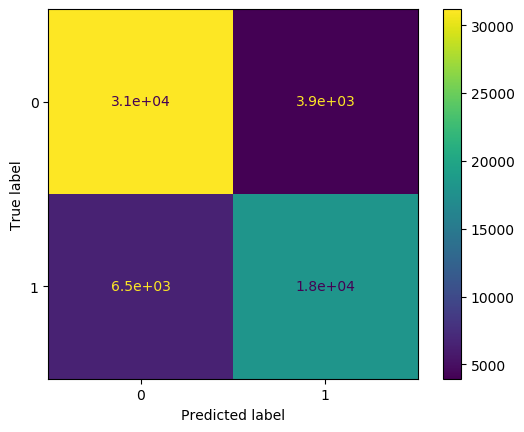



******************** Training category B classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.9559162793807884
F1 score for category B: 0.8283253354729033


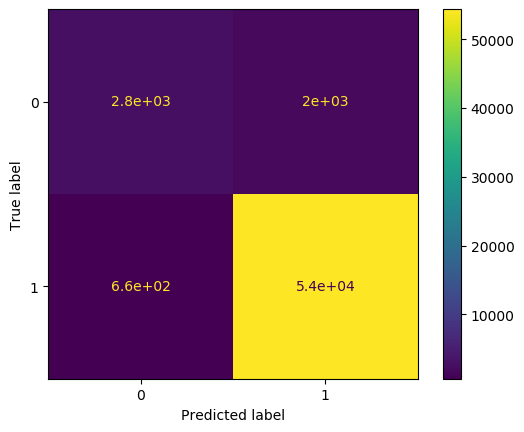



******************** Training category C classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.875355244240864
F1 score for category C: 0.8747582288500515


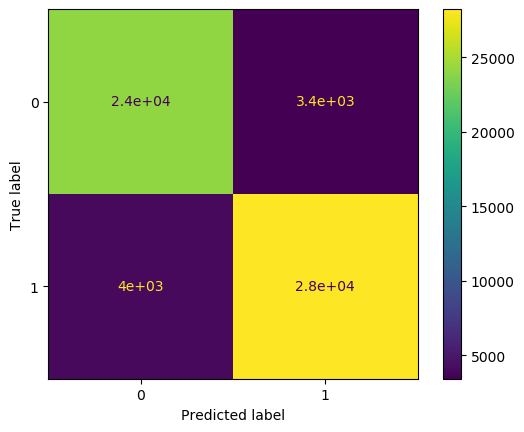



******************** Training category D classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.8799190878999632
F1 score for category D: 0.8756535811848096


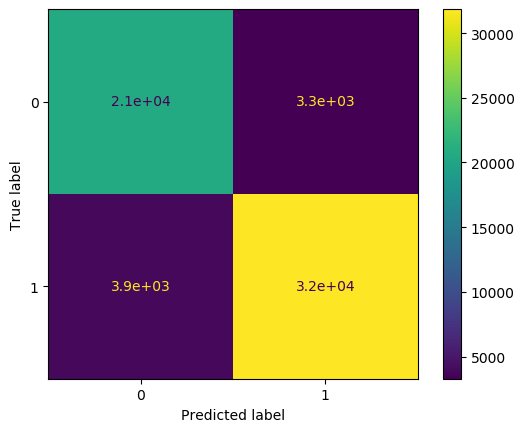



******************** Training category E classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.8075662843960012
F1 score for category E: 0.6594848440588915


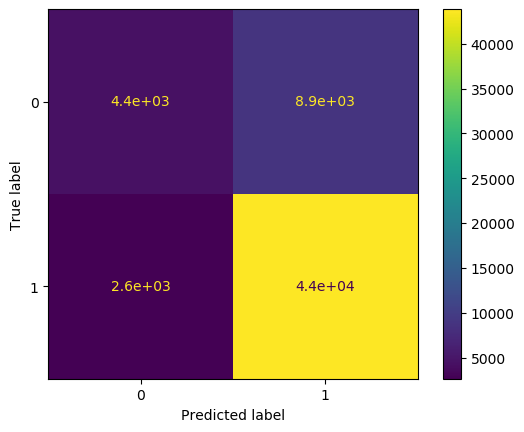



******************** Training category F classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.9123173626667558
F1 score for category F: 0.854482977963531


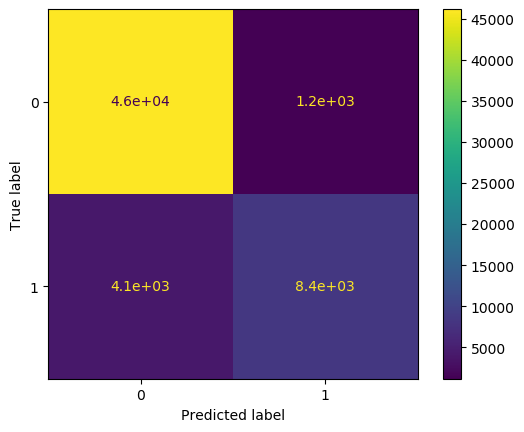



******************** Training category G classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.8129158447290113
F1 score for category G: 0.7775078823380812


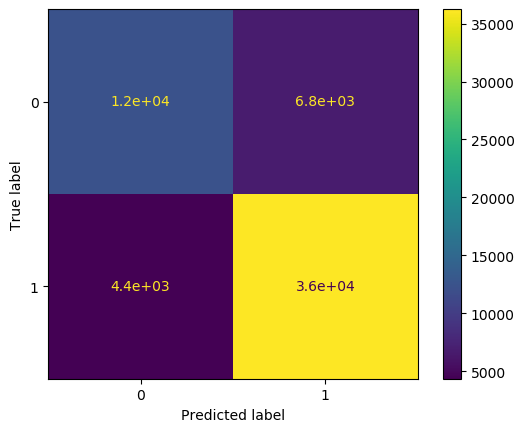



******************** Training category H classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.8822093684175332
F1 score for category H: 0.6062381061713901


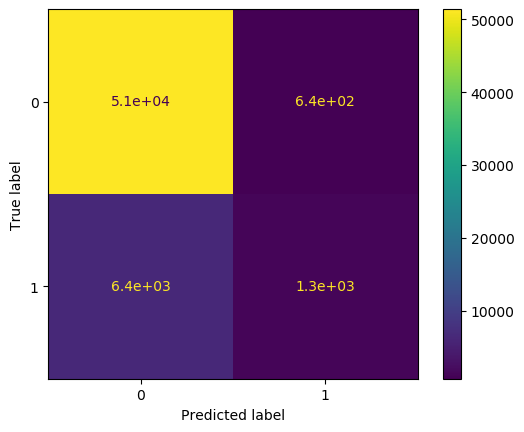



******************** Training category I classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.9130696445885854
F1 score for category I: 0.7751926915656703


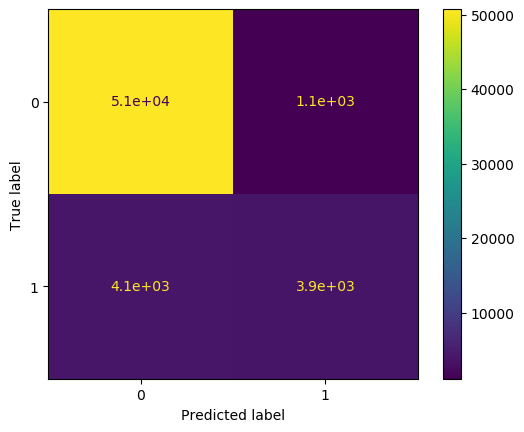



******************** Training category J classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.9079541275201445
F1 score for category J: 0.7621568847185989


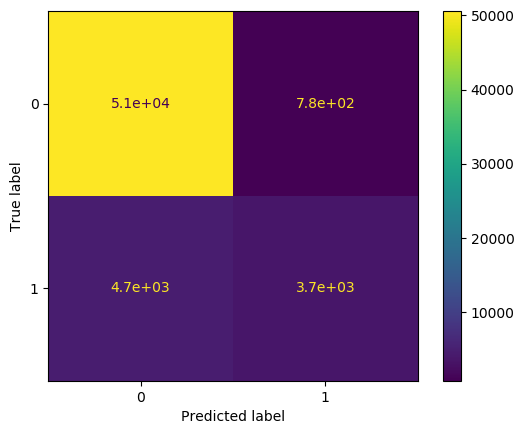



******************** Training category K classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.9764284997826741
F1 score for category K: 0.6744134678254725


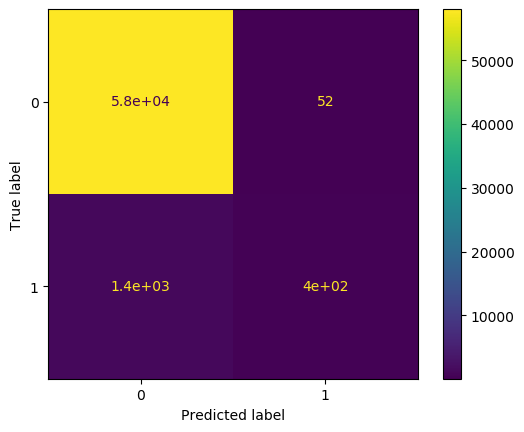



******************** Training category L classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.8803035875488984
F1 score for category L: 0.7215316145842036


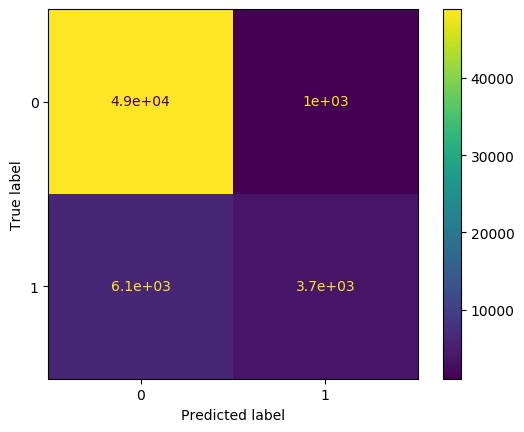



******************** Training category M classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.8872747333578521
F1 score for category M: 0.883491611213809


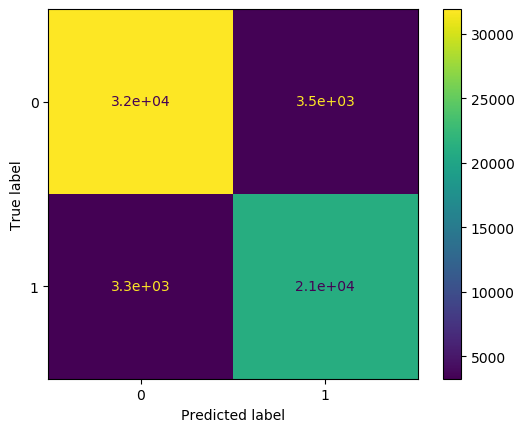



******************** Training category N classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.8135511050185563
F1 score for category N: 0.8125712889320642


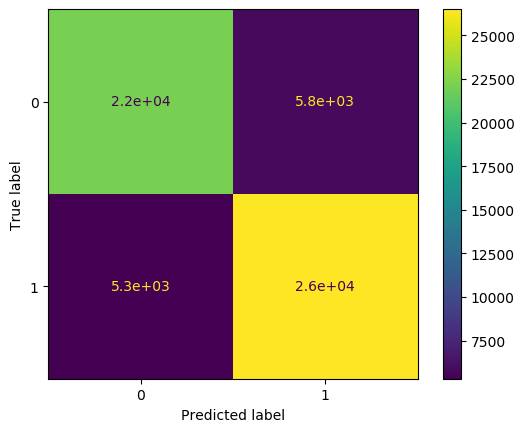



******************** Training category Z classifier ********************
******************** Model Performance ********************
Test accuracy is: 0.8881273195359256
F1 score for category Z: 0.7902160241256684


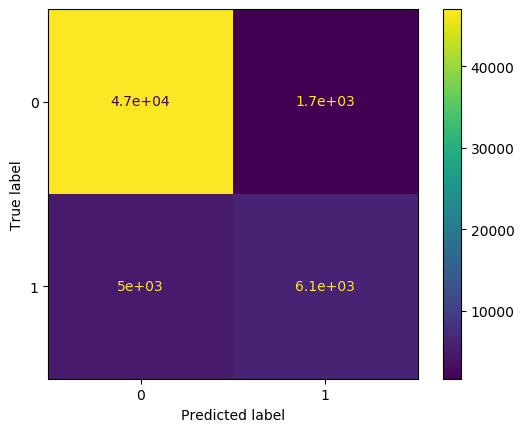

In [19]:
# Do you want to print the results? Then, set this to True
PRINT_RESULT = True
# Store the predicitons from each classifier.
predict_list = []
for category in list(data.columns[-15:]):
    # Define the logistic regression model.
    clf = LogisticRegression(solver='sag', n_jobs=-1)
    if PRINT_RESULT: print(f'{"*"*20} Training category {category} classifier {"*"*20}')
    # Fit the model on the training data.
    clf.fit(X_train_text, train[category])
    # Predict the label category for test example.
    prediction = clf.predict(X_test_text)
    # Store the predicitons.
    predict_list.append(prediction)
    # Test accuracy and F1 score.
    if PRINT_RESULT: print(f'{"*"*20} Model Performance {"*"*20}')
    if PRINT_RESULT: print('Test accuracy is: {}'.format(accuracy_score(test[category], prediction)))
    if PRINT_RESULT: print(f'F1 score for category {category}: {f1_score(test[category], prediction, average="macro")}')
    # Create a confision matrix
    cm = confusion_matrix(test[category], prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()
    plt.savefig(f'{rpath}/cf_{category}.png', bbox_inches='tight')
    plt.show()
    # Store the weights for the top 20 positive words, and top 10 negative words.
    # Store the eli5 result into data tables.
    with open(f"data{category}.html", "w") as file:
      file.write(eli5.show_weights(estimator=clf, 
                  feature_names= list(text_transformer.get_feature_names()),
                 top=(20, 10), target_names = [f'Other than {category}', category]).data)
    print("\n")

### Generate a classification report
We generate a single report that links all the results. Download the zipped result, and open the full_report.html file.

In [19]:
preds_all = np.array([i.tolist() for i in predict_list]).T
true_all = test[data.columns[-15:]].to_numpy()
classification_dict = classification_report(
    true_all, 
    preds_all,
    target_names=data.columns[-15:],
    output_dict=True)
# For each category
for cate in list(data.columns[-15:]):
  # load the file
  with open(f"data{cate}.html") as inf:
      txt = inf.read()
      soup = bs4.BeautifulSoup(txt)
  # edit the HTML
  element_new_h1 = soup.new_tag('h1', attrs={'style': 'text-align: center;'})
  element_new_h1.string = f'Result for category: {cate}'
  soup.body.insert(0, element_new_h1)
  element_new = soup.new_tag('h3', attrs={'style': 'color: blue; text-align: center;'})
  element_new.string = 'Confusion Matrix'
  soup.body.insert(1, element_new)
  new_link = soup.new_tag("img", src=f"cf_{cate}.png", attrs={'style':'display: block;  margin-left: auto;  margin-right: auto; width:30%;'})
  soup.body.find('h3').insert_after(new_link)
  element_new_table_title = soup.new_tag('h3', attrs={'style': 'color: blue; text-align: center;'})
  element_new_table_title.string = f'Feature weights for category {cate}'
  soup.body.find('img').insert_after(element_new_table_title)
  p_element = soup.body.find('p')
  p_element.attrs['style'] = p_element.attrs['style'] + ' ;text-align: center;'
  table_element = soup.body.find('table')
  table_element.attrs['style'] = table_element.attrs['style'] + ' margin-left: auto; margin-right: auto;'
  
  with open(f"{rpath}/processed_report_{cate}.html", "w") as outf:
      outf.write(str(soup))

In [20]:
# Create the full report page
classification_report_table = bs4.BeautifulSoup('''<html><head><style>table a {text-decoration: none; color: black; display: block;}</style></head><body><div style='margin-top: 3rem; margin-left: auto; margin-right: auto; width: 50%; display: block;'>
<table class="demo" style='padding:1rem;text-align: center;margin-left: auto; margin-right: auto;'>
	<caption style='font-size: 1.2rem; font-weight: bold'>Classification Summary Result</caption>
	<thead>
	<tr>
    <th style='padding:1rem;'></th>
		<th style='padding:1rem;'>Precision</th>
		<th style='padding:1rem;'>Recall</th>
		<th style='padding:1rem;'>F1 - Score</th>
		<th style='padding:1rem;'>Support</th>
	</tr>
	</thead>
	<tbody>
	</tbody>
</table>
</div></body></html>''')

# Create the table to add to the full report page.
for table_elements in classification_dict.keys():
  tr = classification_report_table.new_tag('tr')
  td = classification_report_table.new_tag('td', attrs={'style':'padding:0.5rem;'})
  td.string = table_elements.title()
  a = classification_report_table.new_tag('a', attrs={'href':f'processed_report_{table_elements}.html'})
  td.string.wrap(a)
  tr.append(td)
  for i,j in classification_dict[table_elements].items():
    if j > 0.9 and i != 'support':
      td = classification_report_table.new_tag('td', attrs={'style':'padding:0.5rem;background-color: #E2E603'})
    else:
      td = classification_report_table.new_tag('td', attrs={'style':'padding:0.5rem;'})
    td.string = f'{j:.2f}'
    if len(table_elements) == 1:
      a = classification_report_table.new_tag('a', attrs={'href':f'processed_report_{table_elements}.html'})
      td.string.wrap(a)
    tr.append(td)
  table_ref = classification_report_table.find('tbody')
  table_ref.append(tr)

note = classification_report_table.new_tag('p', attrs={'style':'text-align: center; font-size: 1rem; color: red;'})
note.string = 'Note: you can click on the values to get full report for the category.'
classification_report_table.find('html').append(note)

# save the file again
with open(f"{rpath}/full_report.html", "w") as outf:
    outf.write(str(classification_report_table))


### Export the final result to a ZIP file

In [21]:
import shutil
shutil.make_archive('report', 'zip', rpath)

'/root/report.zip'

### Download the result report

In [38]:
from google.colab import files
files.download('report.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Classifier Chains

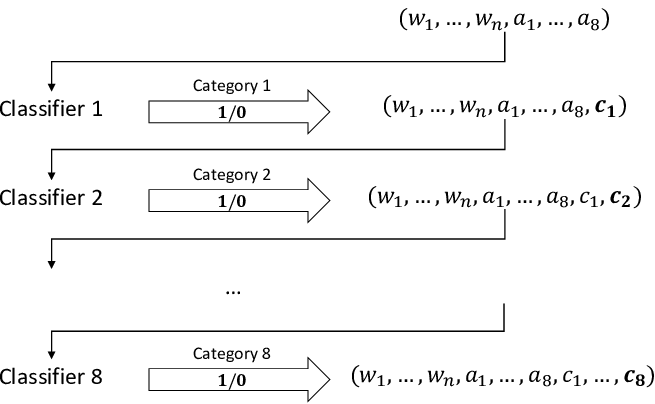

Define a base logistic regression model that we will chain in a random order. This will ensure that the data is shuffled, and we possibly find a better combination of classifier chain order that will maximize our prediction score. In the end, we also build a ensemble model that is combination of all the classifiers.

In [16]:
base_lr = LogisticRegression(n_jobs=-1)
chains = [ClassifierChain(base_lr, order="random", random_state=i) for i in range(len(list(data.columns[-15:])))]
for chain in tqdm(chains):
    chain.fit(X_train_text, train.iloc[:,-15:])

100%|██████████| 15/15 [39:46<00:00, 159.08s/it]


In [17]:
Y_pred_chains = np.array([chain.predict(X_test_text) for chain in chains])

In [20]:
# Calculate the jaccard score for each classifier in the chain
chain_jaccard_scores = [
    jaccard_score(test.iloc[:,-15:], Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

# Ensemble the predictions of all the classifiers.
Y_pred_ensemble = Y_pred_chains.mean(axis=0)

# Ensemble jaccard score
ensemble_jaccard_score = jaccard_score(
    test.iloc[:,-15:], Y_pred_ensemble >= 0.5, average="samples"
)

# OVR Result
Y_pred_ovr = np.array(predict_list).T

Y_test_n = test.iloc[:,-15:].to_numpy()
ovr_jaccard_score = jaccard_score(Y_test_n, Y_pred_ovr, average="samples")

model_scores = [ovr_jaccard_score] + chain_jaccard_scores

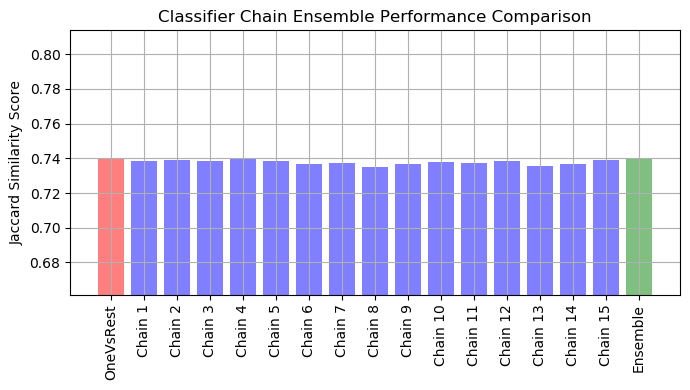

In [21]:
model_scores.append(ensemble_jaccard_score)

model_names = (
    "OneVsRest",
    "Chain 1",
    "Chain 2",
    "Chain 3",
    "Chain 4",
    "Chain 5",
    "Chain 6",
    "Chain 7",
    "Chain 8",
    "Chain 9",
    "Chain 10",
    "Chain 11",
    "Chain 12",
    "Chain 13",
    "Chain 14",
    "Chain 15",
    "Ensemble",
)

x_pos = np.arange(len(model_names))

# Plot the Jaccard similarity scores for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["r"] + ["b"] * len(chain_jaccard_scores) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

## 3. LabelPowerset

This method treats each combination as a single label, and makes 2^15 combinations. This method of calculation is infeasible for our problem.

## 4. Adaptive Algorithm
This method adapts the cost function to the problem. Here we will atempt to use the multi-label lazy learning approach named ML-KNN. 

In [27]:
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=1000)
X_train_text = text_transformer.fit_transform(train['AbstractText'])
X_test_text = text_transformer.transform(test['AbstractText'])

In [28]:
tr = X_train_text.toarray()
te = X_test_text.toarray()
ytr = train.iloc[:,-15:].to_numpy()
yte = test.iloc[:,-15:].to_numpy()

We had to downgrade scikit-learn to less than one. It's an ongoing issue for the package https://github.com/scikit-multilearn/scikit-multilearn/issues/250

Also, note that we are using only 1000 features since for a very large feature set the notebook crashes. The transformed matrix is a very sparse matrix therefore it takes up to very large space in memory.

In [31]:
!pip install scikit_learn==0.24.0

Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 36.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit_learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


In [33]:
!pip install scikit-multilearn

Keyring is skipped due to an exception: 'keyring.backends'


In [ ]:
from skmultilearn.adapt import MLkNN
classifier_new = MLkNN(k=15)
# Note that this classifier can throw up errors when handling sparse matrices.
# Also, with a bad result, i.e., accuracy of 2%, it takes about 22 hours to train. So, excluding
# it because we couldn't run it again.
classifier_new.fit(X = tr, y = ytr.astype('float'))
# predict
predictions_new = classifier_new.predict(te)
# accuracy
print("Accuracy = ",accuracy_score(yte,predictions_new))
print("\n")

In [22]:
!pip install Levenshtein -q

Keyring is skipped due to an exception: 'keyring.backends'


In [23]:
!pip install jaro-winkler -q

Keyring is skipped due to an exception: 'keyring.backends'


In [24]:
from sklearn.metrics import hamming_loss, jaccard_score, classification_report, multilabel_confusion_matrix, f1_score, accuracy_score, log_loss
from Levenshtein import distance as levenshtein_distance
import jaro
import numpy as np
def eval_test_report(true_bools,pred_bools, model_name):
    '''
    true_label: numpy array consisting of list (length 15 = num_labels) of actual labels [1,0,1,...,0]
    true_label: numpy array consisting of list (length 15 = num_labels) of predicted labels [1,0,1,...,0]
    '''
    
    report_dict = {}
    report_dict['jaccard'] = 100.0*jaccard_score(true_bools,pred_bools, average="macro")
    report_dict['f1_score_micro'] = 100.0*f1_score(true_bools, pred_bools,average='micro')
    report_dict['f1_score_macro'] = 100.0*f1_score(true_bools, pred_bools,average='macro')
    report_dict['accuracy_score'] = 100.0*accuracy_score(true_bools, pred_bools)
    
    # lower the better
    report_dict['hamming_loss'] = hamming_loss(true_bools, pred_bools)
    report_dict['log_loss'] = log_loss(true_bools,pred_bools)
    
    # similarity by string matching
    pred_str = [''.join(list(map(str, (list(x))))) for x in list(pred_bools)]
    true_str = [''.join(list(map(str, (list(x))))) for x in list(true_bools)]



    sim = []
    i = 0
    while i < len(pred_str):
        sim.append(jaro.jaro_winkler_metric(true_str[i],pred_str[i]))
        i+=1
    
    report_dict['jaro_mean'] = 100.0*np.mean(sim)
    
    sim = []
    i = 0
    while i < len(pred_str):
        sim.append(levenshtein_distance(true_str[i],pred_str[i]))
        i+=1
    
    report_dict['lev_mean'] = np.mean(sim)
    
#     print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories)
    final = {model_name: report_dict}
    
    return pd.DataFrame(final)

In [25]:
eval_test_report(Y_test_n, Y_pred_ovr, 'OVR')

,OVR
accuracy_score,15.858103
f1_score_macro,71.382164
f1_score_micro,84.388621
hamming_loss,0.118796
jaccard,59.097752
jaro_mean,92.511068
lev_mean,1.755157
log_loss,46.159309


In [29]:
eval_test_report(Y_test_n, Y_pred_ensemble >= 0.5, 'Chain Ensemble')

,Chain Ensemble
accuracy_score,16.332876
f1_score_macro,71.492478
f1_score_micro,84.388639
hamming_loss,0.118876
jaccard,59.196193
jaro_mean,0.000000
lev_mean,69.438146
log_loss,46.037329


In [30]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_n, Y_pred_ovr, target_names=list(train.columns[-15:])))

              precision    recall  f1-score   support

           A       0.82      0.74      0.78     24695
           B       0.96      0.99      0.98     55032
           C       0.89      0.88      0.88     32271
           D       0.91      0.89      0.90     35756
           E       0.83      0.94      0.88     46510
           F       0.88      0.68      0.76     12483
           G       0.84      0.89      0.87     40604
           H       0.68      0.17      0.28      7755
           I       0.78      0.49      0.60      7977
           J       0.83      0.44      0.58      8465
           K       0.88      0.23      0.36      1756
           L       0.78      0.38      0.51      9856
           M       0.86      0.87      0.86     24418
           N       0.82      0.83      0.83     31817
           Z       0.79      0.55      0.65     11152

   micro avg       0.87      0.82      0.84    350547
   macro avg       0.84      0.66      0.71    350547
weighted avg       0.86   

In [32]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_n,  Y_pred_ensemble >= 0.5, target_names=list(train.columns[-15:])))

              precision    recall  f1-score   support

           A       0.81      0.76      0.78     24695
           B       0.97      0.99      0.98     55032
           C       0.89      0.88      0.88     32271
           D       0.90      0.89      0.90     35756
           E       0.84      0.93      0.88     46510
           F       0.87      0.67      0.76     12483
           G       0.84      0.89      0.87     40604
           H       0.68      0.17      0.28      7755
           I       0.78      0.48      0.60      7977
           J       0.83      0.44      0.58      8465
           K       0.87      0.24      0.37      1756
           L       0.78      0.38      0.51      9856
           M       0.86      0.87      0.86     24418
           N       0.82      0.83      0.82     31817
           Z       0.78      0.56      0.65     11152

   micro avg       0.87      0.82      0.84    350547
   macro avg       0.83      0.67      0.71    350547
weighted avg       0.86   